In [6]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

data_path = 'dataset/train'

transform_img = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    # here do not use transforms.Normalize(mean, std)
])

image_data = torchvision.datasets.ImageFolder(
  root=data_path, transform=transform_img
)

image_data_loader = DataLoader(
  image_data, 
  batch_size=len(image_data), 
  shuffle=False, 
  num_workers=0
)

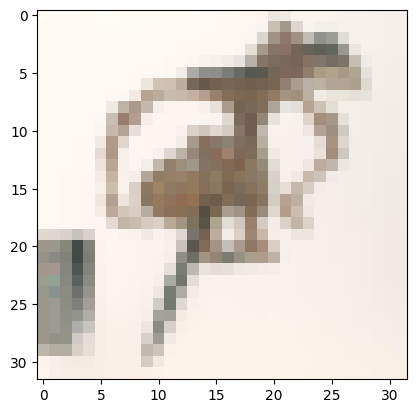

In [7]:
# Python code to visualize an image
import matplotlib.pyplot as plt

images, labels = next(iter(image_data_loader))

def display_image(images):
  images_np = images.numpy()
  img_plt = images_np.transpose(0,2,3,1)
  # display 5th image from dataset
  plt.imshow(img_plt[4])

display_image(images)

In [8]:
# python code calculate mean and std
from torch.utils.data import DataLoader
image_data_loader = DataLoader(
    image_data,
    # batch size is whole dataset
    batch_size=len(image_data),
    shuffle=False,
    num_workers=0)
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.6628, 0.6246, 0.5834]) tensor([0.2829, 0.2980, 0.3196])
